In [11]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord

# utils
import sys
sys.path.append('../utils')
from utils import partial_corr, tp_fp, mcc, precision_recall, pseudo_BIC, gauss_BIC, proj_precision_mat
from generate_graphs import generate_erdos_renyi, generate_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get graph and data (Erdos-Renyi)

In [2]:
n, p = 500, 1000
n_prop_to_p = [0.5]
Theta, Sigma = generate_erdos_renyi(p, type='proj', edge_prob=0.01, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2023)
Partial_corr = partial_corr(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Run ACCORD, CONCORD, Glasso

In [7]:
S = np.matmul(X.T, X)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
lams = lams[::-1][7:19] # pre-selected lambdas for erdos-renyi

p_bics, ep_bics_01, ep_bics_02, gauss_bics = [], [], [], []
edges, precs, recalls, mccs = [], [], [], []

for lam in lams:
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500)
    model.fit(X)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))

    p_bics.append(pseudo_BIC(X, Theta_hat, modified=False))
    ep_bics_01.append(pseudo_BIC(X, Theta_hat, modified=True, gamma=0.1))
    ep_bics_02.append(pseudo_BIC(X, Theta_hat, modified=True, gamma=0.2))
    gauss_bics.append(gauss_BIC(X, Theta_hat))

    tp, fp = tp_fp(Theta, Theta_hat)
    edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    precs.append(prec)
    recalls.append(recall)
    mccs.append(mcc(Theta, Theta_hat))

    print('lam:', np.round(lam, 3), ', TP:', tp, ', FP:', fp,\
           ', MCC:', np.round(mcc(Theta, Theta_hat),2),\
           'Precision:', np.round(prec,2),\
           'Recall:', np.round(recall,2))
    
best_p_bic = np.argmin(p_bics)
best_ep_bic_01 = np.argmin(ep_bics_01)
best_ep_bic_02 = np.argmin(ep_bics_02)
best_gauss_bic = np.argmin(gauss_bics)

lam: 0.212 , TP: 958 , FP: 0 , MCC: 0.44 Precision: 1.0 Recall: 0.2
lam: 0.196 , TP: 1481 , FP: 1 , MCC: 0.55 Precision: 1.0 Recall: 0.3
lam: 0.181 , TP: 1984 , FP: 3 , MCC: 0.63 Precision: 1.0 Recall: 0.41
lam: 0.167 , TP: 2489 , FP: 31 , MCC: 0.71 Precision: 0.99 Recall: 0.51
lam: 0.154 , TP: 2950 , FP: 112 , MCC: 0.76 Precision: 0.96 Recall: 0.6
lam: 0.143 , TP: 3345 , FP: 363 , MCC: 0.78 Precision: 0.9 Recall: 0.68
lam: 0.132 , TP: 3699 , FP: 894 , MCC: 0.78 Precision: 0.81 Recall: 0.76
lam: 0.122 , TP: 3961 , FP: 2040 , MCC: 0.73 Precision: 0.66 Recall: 0.81
lam: 0.112 , TP: 4184 , FP: 4079 , MCC: 0.65 Precision: 0.51 Recall: 0.85
lam: 0.104 , TP: 4344 , FP: 7314 , MCC: 0.57 Precision: 0.37 Recall: 0.89
lam: 0.096 , TP: 4463 , FP: 12063 , MCC: 0.49 Precision: 0.27 Recall: 0.91
lam: 0.089 , TP: 4545 , FP: 18411 , MCC: 0.42 Precision: 0.2 Recall: 0.93


### Visualization

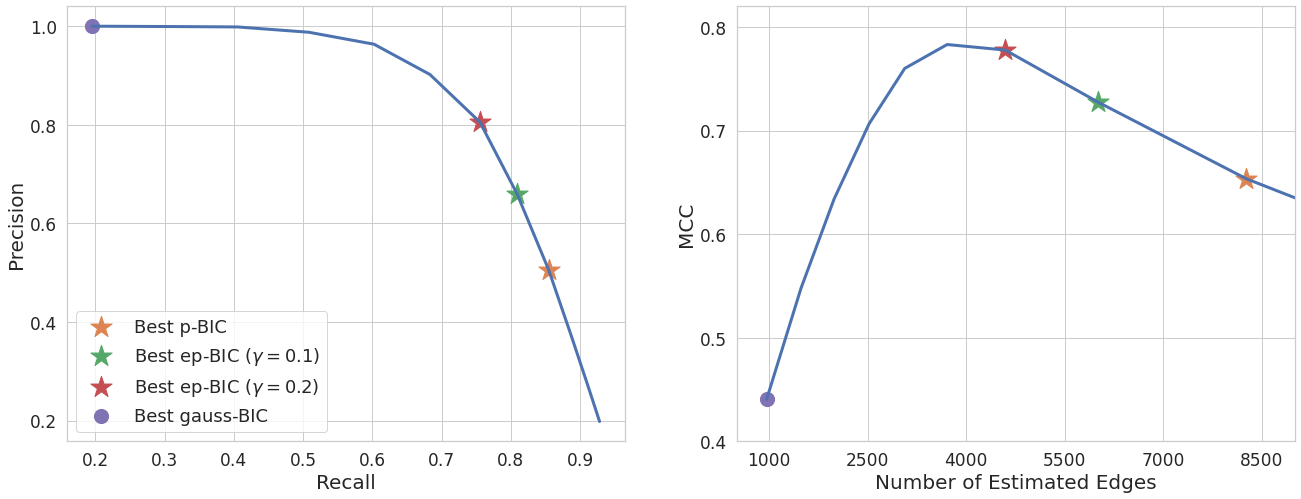

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(recalls, precs, linewidth=3)
axes[i].scatter(recalls[best_p_bic], precs[best_p_bic], marker='*', s=500, color=sns.color_palette()[1], label='Best p-BIC')
axes[i].scatter(recalls[best_ep_bic_01], precs[best_ep_bic_01], marker='*', s=500, color=sns.color_palette()[2], label='Best ep-BIC ($\gamma = 0.1$)')
axes[i].scatter(recalls[best_ep_bic_02], precs[best_ep_bic_02], marker='*', s=500, color=sns.color_palette()[3], label='Best ep-BIC ($\gamma = 0.2$)')
axes[i].scatter(recalls[best_gauss_bic], precs[best_gauss_bic], marker='o', s=200, color=sns.color_palette()[4], label='Best gauss-BIC')
axes[i].set_xlabel('Recall', fontsize=20)
axes[i].set_ylabel('Precision', fontsize=20)
axes[i].set_yticks(np.arange(0.2, 1.2, 0.2))
axes[i].tick_params(axis='both', which='major', labelsize=17)
axes[i].legend(fontsize=18)

i = 1
axes[i].plot(edges, mccs, linewidth=3)
axes[i].scatter(edges[best_p_bic], mccs[best_p_bic], marker='*', s=500, color=sns.color_palette()[1], label='Best p-BIC')
axes[i].scatter(edges[best_ep_bic_01], mccs[best_ep_bic_01], marker='*', s=500, color=sns.color_palette()[2], label='Best ep-BIC ($\gamma = 0.1$)')
axes[i].scatter(edges[best_ep_bic_02], mccs[best_ep_bic_02], marker='*', s=500, color=sns.color_palette()[3], label='Best ep-BIC ($\gamma = 0.2$)')
axes[i].scatter(edges[best_gauss_bic], mccs[best_gauss_bic], marker='o', s=200, color=sns.color_palette()[4], label='Best gauss-BIC')
axes[i].set_xlabel('Number of Estimated Edges', fontsize=20)
axes[i].set_ylabel('MCC', fontsize=20)
axes[i].set_xlim((500,9000))
axes[i].set_ylim((0.4,0.82))
axes[i].set_xticks(np.arange(1000, 9500, 1500))
axes[i].set_yticks(np.arange(0.4, 0.9, 0.1))
axes[i].tick_params(axis='both', which='major', labelsize=17)

plt.savefig('../output/model-selection.png', bbox_inches='tight')